The cell below imports all the required libraries and defines key variables. You'll have to run cells one at a time from top to bottom. If you run them out of order, things won't work.

This notebook will closely follow the tutorial here - https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html.

In [36]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.integrate import quad

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile # From the lightkurve library, import the search_targetpixelfile method.

In [18]:
# Give your planet name - be sure to spell everything exactly right. Otherwise, the package won't find the data.
planet_name = "XO-1"

# Open a Target Pixel File from MAST and download one data file.
tpf = search_targetpixelfile(planet_name).download()

# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).remove_nans()
print(lc) # You should see a table of data below that looks like (but not exactly like) the pasted text below.
#  time            flux          flux_err     ... cadenceno quality
#                    electron / s    electron / s   ...                  
# ------------------ ------------ ----------------- ... --------- -------
# 120.52924274596444 401333.15625 91.52275085449219 ...      5500       0

       time              flux           flux_err      ... cadenceno quality
                     electron / s     electron / s    ...                  
------------------ --------------- ------------------ ... --------- -------
1955.7990267537568 9087.6220703125  12.76364517211914 ...    524405       0
1955.8004156718298    9094.9296875 12.802447319030762 ...    524406       0
1955.8018045901358 9065.2783203125 12.754873275756836 ...    524407       0
 1955.803193508209  9066.900390625   12.7570161819458 ...    524408       0
 1955.804582426282 9066.4423828125 12.756695747375488 ...    524409       0
 1955.805971344355 9077.1083984375 12.761527061462402 ...    524410       0
               ...             ...                ... ...       ...     ...
1982.2757545071158 9052.1884765625 12.730691909790039 ...    543468       0
1982.2771433958524  9067.294921875 12.760944366455078 ...    543469       0
1982.2785322841232  9049.568359375 12.730385780334473 ...    543470       0
1982.2799211

/Users/brian/opt/anaconda3/envs/PHYS305_Observing_Project/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Let's start by plotting your data. As a general rule, you should always inspect any data you intend to use and do NOT just assume the data are fine.

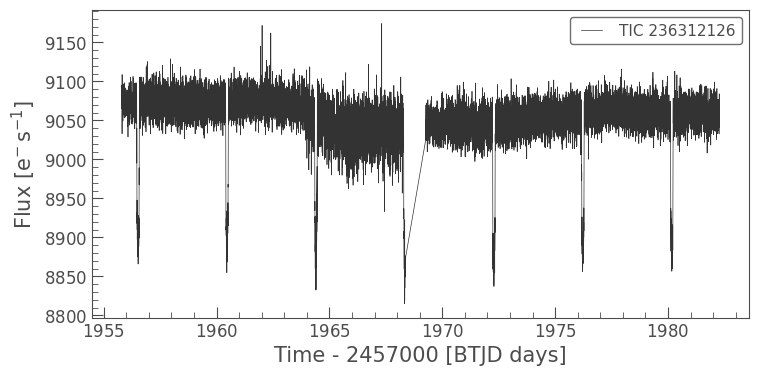

In [10]:
lc.plot();

Hopefully, what you see above is a series of transit dips, probably with some scatter. 

In some cases, you may also see individual points with excursions unassociated with the transit dips, which we'll call "single-point outliers". 

There may also be some up-and-down wobbles unassocated with the transit dips. We'll call these signals "systematic noise".

In order to conduct our transit analysis, we will need to remove as much of those sources of noise as possible. 

---

### Removing Single-Point Outliers

Since the single-point outliers are big, discrete jumps, we can try to find them by using the technique we talked about in class before: calculating the derivative of the time-series and then looking for big outlier values.

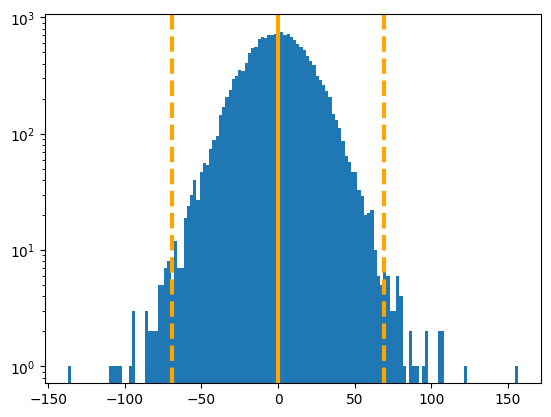

In [97]:
# Calculate the derivative
df = np.diff(lc['flux']).value
num_sigma = 5.

# Calculate the median value
med = np.median(df)
# Calculate the standard deviation
std = mad(df)

# Make a histogram showing the distribution of derivative values.
plt.hist(df, bins='auto');
plt.yscale('log') # Make it easier to the outliers

# Add in lines showing the expected width of the distribution if it were just Gaussian.
plt.axvline(med, lw=3, color='orange')
plt.axvline(med - num_sigma*std, lw=3, color='orange', ls='--')
plt.axvline(med + num_sigma*std, lw=3, color='orange', ls='--')

Remember that we often approximate the noise in a dataset as a Gaussian distribution. That means we can *assume* a Gaussian distribution and then figure out which points in our dataset deviate from Gaussian. We'll toss those points as our single-point outliers.

If everything above worked correctly, you should see a histogram of derivative values, along with some orange lines showing the median (center) of the distribution and two dashed lines showing $\pm5 \sigma$, i.e. the maximum expected width for a Gaussian distribution. 

If the dataset were truly Gaussian, we would expect datapoints to lie more than $5 \sigma$ from the median value with a probability of about 1 in $10^12$. Since we only have a few thousand datapoints, we shouldn't expect to see any points at those distances from the median at all. That means we can safely treat points that lie outside that range as outliers.

[ -74.17578    71.85156   106.85547  -103.72949    77.615234   77.84473
  -96.07129    80.884766  -70.990234  -81.23926   108.49121   -76.08594
   93.87891    78.506836  -72.06348    74.98242   -73.63672   -74.88867
   70.890625  -70.73926    76.94629   -70.34375    83.00781    80.70801
  -73.97461   -75.822266  -78.62793    76.990234  -77.60742    69.427734
  -79.10156   -85.578125   90.15527   -95.086914   71.45215   -93.62402
  106.12109   -76.95801    73.59473   -76.0166     70.38086   -83.0332
  -70.62109    97.69336   -93.91992   105.7168    -72.634766   87.708984
   77.48926   -70.34473    85.59375   -71.03125   -72.55859    86.24609
  -83.41797   -85.884766   70.4541     80.33887   121.600586 -105.99707
  -76.42676    69.94629    96.91797  -137.26465    80.850586  -72.87793
  -77.19824    69.6084    -77.512695  -86.00195    71.631836  -72.646484
   70.799805   70.62793    70.20117  -109.84375   -82.56055    74.58984
 -103.59766   156.84375    70.37988    71.30371   -69.8125    

(9000.0, 9200.0)

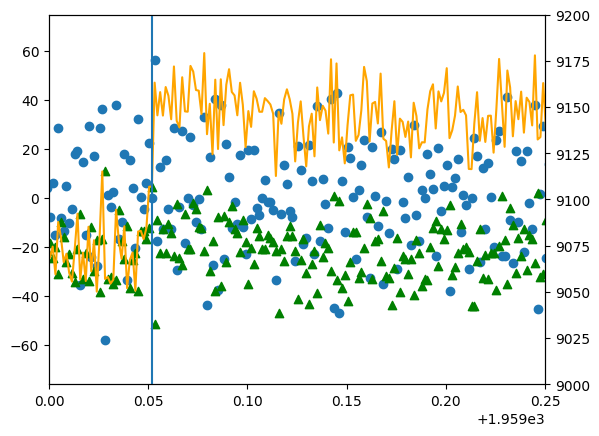

In [101]:
# Find the outlier points
df = np.diff(lc['flux']).value
ind = np.abs(df - med) > num_sigma*std

# Replace the outlier points with average points
print(df[ind])
df[ind] = med
print(df[ind])

# Integrate the derivative to make a time-series again.
f = np.cumsum(df) + lc.flux[0].value

print(type(lc.time[:-1].value))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.plot(lc.time[:-1].value, f, color='orange')
ax1.scatter(lc.time[:-1].value, df, zorder=3)
ax2.scatter(lc.time.value, lc.flux.value, marker='^', color='green')

for i in range(len(df[ind])):
    plt.axvline(lc.time[:-1].value[ind][i])
plt.xlim([1959, 1959.25])
plt.ylim([9000, 9200])